In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import  splrep, splev
import scipy.stats as st

from utils.tools import *

import torch
from torch import nn

# 1. GAN selection 20 steps

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class CNNGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(    
            nn.ConvTranspose1d(20, 10, kernel_size = 5, stride = 2, padding = 0, bias = False),
            nn.BatchNorm1d(10),
            nn.ReLU(True),

            nn.ConvTranspose1d(10, 5, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(5),
            nn.ReLU(True),

            nn.ConvTranspose1d(5, 2, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.Tanh()
         )
        

    def forward(self, z, batch_size):    
        out = self.cnn(z)
        return out

class LSTMGenerator(nn.Module):
    """An LSTM based generator. It expects a sequence of noise vectors as input.
    Args:
        in_dim: Input noise dimensionality
        out_dim: Output dimensionality
        n_layers: number of lstm layers
        hidden_dim: dimensionality of the hidden layer of lstms
    Input: noise of shape (batch_size, seq_len, in_dim)
    Output: sequence of shape (batch_size, seq_len, out_dim)
    """
    def __init__(self):
        super().__init__()

        self.lstm = nn.LSTM(1, 16, 1, batch_first=True, bias = True)
        self.linear = nn.Sequential(
                        nn.ReLU(),
                        nn.Linear(16, 16),
                        nn.ReLU(),
                        nn.Linear(16, 2),
                        nn.Tanh()
                      )

    def forward(self, x, batch_size):  

        h_0 = torch.autograd.Variable(torch.randn(1, batch_size, 16)).to(device) #hidden state
        c_0 = torch.autograd.Variable(torch.randn(1, batch_size, 16)).to(device) #hidden state

        # init LSTM cells  (batch, seq, feature)
        out, h_n = self.lstm(x, (h_0, c_0))
        out = self.linear(out)
        out = out.view(batch_size, 2, 20)
        return torch.cumsum(out, 2)

In [3]:
cnn_cnn = torch.load('../results/cnn_cnn_20_steps_SS_G.pt', map_location=torch.device('cpu'))
lstm_lstm = torch.load('../results/lstm_lstm_20_steps_SS_G.pt', map_location=torch.device('cpu'))
cnn_lstm = torch.load('../results/cnn_lstm_20_steps_SS_G.pt', map_location=torch.device('cpu'))
lstm_cnn = torch.load('../results/lstm_cnn_20_steps_SS_G.pt', map_location=torch.device('cpu'))

In [4]:
data = pd.read_table('../data/trips_SS_20_steps.csv', sep = ',')
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

# colony = (-77.264, -11.773)
colony =  (-32.392, -3.819)
scale = 2e5

data = format_data(data, colony, scale)
data = data[data.dist_colony > 1000]

padding = 20
traj = padding_data(data, padding)

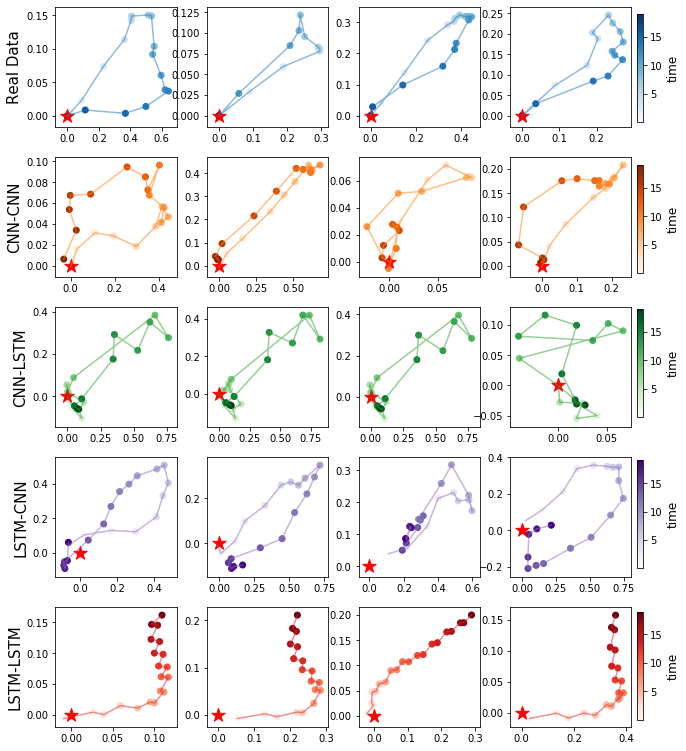

In [5]:
plt.figure(figsize=(8,10))

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.25, hspace=0.25)

nb = 4

for i in range(nb):
    plt.subplot(5,4,i+1)
    plt.plot(traj[i,0,:], traj[i,1,:], c = dicolour['blue'], alpha = 0.5)
    a = plt.scatter(traj[i,0,:], traj[i,1,:], c=np.arange(traj.shape[2]), cmap='Blues')
    plt.scatter(0,0, c = 'red', marker ='*', s=200)
#     plt.xlim(-0.1,0.7)
#     plt.ylim(-0.1,0.7)
#     plt.yticks([-1, 0, 1], ["-1", "0", "1"])
    if i == 0:
        plt.ylabel('Real Data', fontsize=15)
        
        
nb = 4
z = torch.rand((nb, 20, 1))
traj_sim = cnn_cnn(z, nb).detach().numpy()

for i in range(nb):
    plt.subplot(5,4,i+1+4)
    plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = dicolour['orange'], alpha = 0.5)
    b = plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Oranges')
    plt.scatter(0,0, c = 'red', marker ='*', s=200)
#     plt.xlim(-0.1,0.7)
#     plt.ylim(-0.1,0.7)
#     plt.yticks([-1, 0, 1], ["-1", "0", "1"])
    if i == 0:
        plt.ylabel('CNN-CNN', fontsize=15)
        
nb = 4
z = torch.rand((nb, 20, 1))
traj_sim = cnn_lstm(z, nb).detach().numpy()

for i in range(nb):
    plt.subplot(5,4,i+1+8)
    plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = dicolour['green'], alpha = 0.5)
    c=plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Greens')
    plt.scatter(0,0, c = 'red', marker ='*', s=200)
#     plt.xlim(-0.1,0.7)
#     plt.ylim(-0.1,0.7)
#     plt.yticks([-1, 0, 1], ["-1", "0", "1"])
    if i == 0:
        plt.ylabel('CNN-LSTM', fontsize=15)

# plt.subplot(4,5,10)


nb = 4
z = torch.rand((nb, 20, 1))
traj_sim = lstm_cnn(z, nb).detach().numpy()

for i in range(nb):
    plt.subplot(5,4,i+1+12)
    plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = dicolour['purple'], alpha = 0.5)
    d=plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Purples')
    plt.scatter(0,0, c = 'red', marker ='*', s=200)
#     plt.xlim(-0.1,0.7)
#     plt.ylim(-0.1,0.7)
#     plt.yticks([-1, 0, 1], ["-1", "0", "1"])
    if i == 0:
        plt.ylabel('LSTM-CNN', fontsize=15)

nb = 4
z = torch.rand((nb, 20, 1))
traj_sim = lstm_lstm(z, nb).detach().numpy()

for i in range(nb):
    plt.subplot(5,4,i+1+16)
    plt.plot(traj_sim[i,0,:], traj_sim[i,1,:], c = dicolour['red'], alpha = 0.5)
    e=plt.scatter(traj_sim[i,0,:], traj_sim[i,1,:], c=np.arange(traj_sim.shape[2]), cmap='Reds')
    plt.scatter(0,0, c = 'red', marker ='*', s=200)
#     plt.xlim(-0.1,0.7)
#     plt.ylim(-0.1,0.7)
#     plt.yticks([-1, 0, 1], ["-1", "0", "1"])
    if i == 0:
        plt.ylabel('LSTM-LSTM', fontsize=15)


cax = plt.axes([1.01, 0.84, 0.01, 0.15])
cbar = plt.colorbar(a, cax=cax, ticks=[5, 10, 15])
cbar.set_label('time', fontsize=12)

cax = plt.axes([1.01, 0.63, 0.01, 0.15])
cbar = plt.colorbar(b, cax=cax, label = 'time', ticks=[5, 10, 15])
cbar.set_label('time', fontsize=12)

cax = plt.axes([1.01, 0.43, 0.01, 0.15])
cbar = plt.colorbar(c, cax=cax, label = 'time', ticks=[5, 10, 15])
cbar.set_label('time', fontsize=12)

cax = plt.axes([1.01, 0.22, 0.01, 0.15])
cbar = plt.colorbar(d, cax=cax, label = 'time', ticks=[5, 10, 15])
cbar.set_label('time', fontsize=12)

cax = plt.axes([1.01, 0.01, 0.01, 0.15])
cbar = plt.colorbar(e, cax=cax, label = 'time', ticks=[5, 10, 15])
cbar.set_label('time', fontsize=12)

plt.show()

Text(0, 0.5, 'Distance to True Spectral Density')

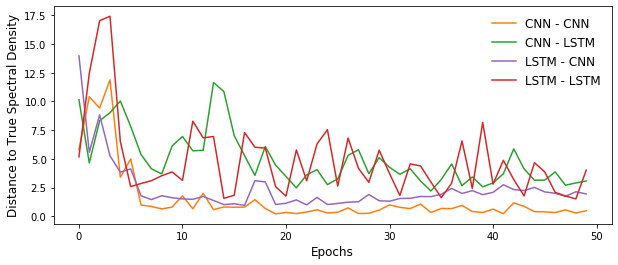

In [6]:
score = np.load('../results/score_20_steps_SS.npy')

plt.figure(figsize=(10,4))
plt.plot(score[0,:], c = dicolour['orange'], label = "CNN - CNN")
plt.plot(score[1,:], c = dicolour['green'], label = "CNN - LSTM")
plt.plot(score[2,:], c = dicolour['purple'], label = "LSTM - CNN")
plt.plot(score[3,:], c = dicolour['red'], label = "LSTM - LSTM")
plt.legend(fontsize = 12, frameon=False)
plt.xlabel('Epochs', fontsize = 12)
plt.ylabel('Distance to True Spectral Density', fontsize = 12)


In [7]:
score[:,-1]

array([0.47078249, 3.06998372, 1.93867324, 4.00832667])

In [8]:
time = np.load('../results/computation_time_20_steps_SS.npy')
time/60

array([1.95685392, 3.03490536, 2.69933567, 3.5931043 ])

Text(0.5, 1.0, 'Latitude')

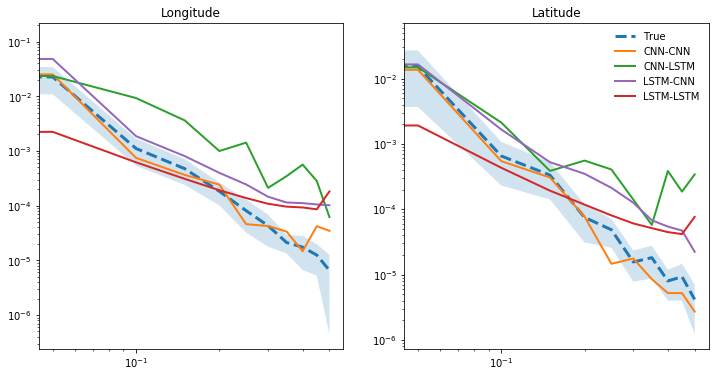

In [9]:
nb = 100

x, lon, lat = get_periodogram(traj)

z = torch.rand((nb, 20, 1))
traj_sim = cnn_cnn(z, nb).detach().numpy()
x, lon_cnn_cnn, lat_cnn_cnn = get_periodogram(traj_sim)

z = torch.rand((nb, 20, 1))
traj_sim = lstm_cnn(z, nb).detach().numpy()
x, lon_lstm_cnn, lat_lstm_cnn = get_periodogram(traj_sim)

z = torch.rand((nb, 20, 1))
traj_sim = cnn_lstm(z, nb).detach().numpy()
x, lon_cnn_lstm, lat_cnn_lstm = get_periodogram(traj_sim)

z = torch.rand((nb, 20, 1))
traj_sim = lstm_lstm(z, nb).detach().numpy()
x, lon_lstm_lstm, lat_lstm_lstm = get_periodogram(traj_sim)



plt.figure(figsize = (12,6))

plt.subplot(1,2,1)
plt.loglog(x, np.mean(lon, axis=0), linewidth = 3, linestyle = '--')
plt.fill_between(x, np.mean(lon, axis=0) - 0.5 * np.std(lon, axis=0) ,
            np.mean(lon, axis=0) + 0.5 * np.std(lon, axis=0),
            alpha = 0.2)


plt.loglog(x, np.mean(lon_cnn_cnn, axis=0), linewidth = 2, c=dicolour['orange'])
plt.loglog(x, np.mean(lon_cnn_lstm, axis=0), linewidth = 2, c=dicolour['green'])
plt.loglog(x, np.mean(lon_lstm_cnn, axis=0), linewidth = 2, c=dicolour['purple'])
plt.loglog(x, np.mean(lon_lstm_lstm, axis=0), linewidth = 2, c=dicolour['red'])
plt.title('Longitude')

plt.subplot(1,2,2)
plt.loglog(x, np.mean(lat, axis=0), linewidth = 3, linestyle = '--', label = 'True')
plt.fill_between(x, np.mean(lat, axis=0) - 0.5 * np.std(lat, axis=0) ,
            np.mean(lat, axis=0) + 0.5 * np.std(lat, axis=0),
            alpha = 0.2)

plt.loglog(x, np.mean(lat_cnn_cnn, axis=0), linewidth = 2, c=dicolour['orange'], label = 'CNN-CNN')
plt.loglog(x, np.mean(lat_cnn_lstm, axis=0), linewidth = 2, c=dicolour['green'], label = 'CNN-LSTM')
plt.loglog(x, np.mean(lat_lstm_cnn, axis=0), linewidth = 2, c=dicolour['purple'], label = 'LSTM-CNN')
plt.loglog(x, np.mean(lat_lstm_lstm, axis=0), linewidth = 2, c=dicolour['red'], label = 'LSTM-LSTM')
# plt.xlim([0, 0.5])
# plt.ylim([1e-6, 1e1])
plt.legend(frameon=False)
plt.title('Latitude')
    
    

# 2. GAN vs HMM - 200 steps

In [10]:
class CNNGenerator1(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(    
            nn.ConvTranspose1d(256, 128, kernel_size = 25, stride = 2, padding = 0, bias = False),
            nn.BatchNorm1d(128),
            nn.ReLU(True),

            nn.ConvTranspose1d(128, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(32),
            nn.ReLU(True),

            nn.ConvTranspose1d(32, 8, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(8),
            nn.ReLU(True),

            nn.ConvTranspose1d(8, 2, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.Tanh()
         )

    def forward(self, z):    
        out = self.cnn(z)

        return out

class CNNDiscriminator1(nn.Module):
    def __init__(self):
        super().__init__()
                
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 8, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(8),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(8, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(32, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(128, 1, kernel_size=25, stride=2, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.cnn(x)
        return out.squeeze(1)


class CNNGenerator2(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(    
            nn.ConvTranspose1d(256, 128, kernel_size = 25, stride = 2, padding = 0, bias = False),
            nn.BatchNorm1d(128),
            nn.ReLU(True),

            nn.ConvTranspose1d(128, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(64),
            nn.ReLU(True),

            nn.ConvTranspose1d(64, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(32),
            nn.ReLU(True),

            nn.ConvTranspose1d(32, 16, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(16),
            nn.ReLU(True),

            nn.Conv1d(16, 8, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.ReLU(True),
            nn.Conv1d(8, 2, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.Tanh()

         )

    def forward(self, z):    
        out = self.cnn(z)

        return out


class CNNDiscriminator2(nn.Module):
    def __init__(self):
        super().__init__()
                
        self.cnn = nn.Sequential(
            
            nn.Conv1d(2, 8, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.LeakyReLU(0.2, inplace=False),
            nn.Conv1d(8, 16, kernel_size = 3, stride = 1, padding = 1, bias = False),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(16, 32, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(32, 64, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(64, 128, kernel_size = 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=False),

            nn.Conv1d(128, 1, kernel_size=25, stride=2, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.cnn(x)
        return out.squeeze(1)

In [11]:
generator_SV = torch.load('../results/G_SV_2.pt', map_location=torch.device('cpu'))
generator_SD = torch.load('../results/G_SD_2.pt', map_location=torch.device('cpu'))


nb = 300

z = torch.randn((nb, 256, 1))
traj_GAN_SD = generator_SD(z).detach().numpy()
traj_GAN_SV = generator_SV(z).detach().numpy()

In [12]:
data_GAN_SD = format_simulation(traj_GAN_SD, (-32.392, -3.819),  2e5)
data_GAN_SV = format_simulation(traj_GAN_SV, (-77.264, -11.773), 5e4)

In [13]:
data_GAN_SD = data_GAN_SD[data_GAN_SD.dist_colony > 1000]
data_GAN_SV = data_GAN_SV[data_GAN_SV.dist_colony > 1000]

In [14]:
simHMM_raw = pd.read_table("/home/amdroy/MEGA/SCRIPT/BirdGAN/results/sim_HMM_SD.csv", sep =',')

colony = (-32.392, -3.819)
simHMM_raw['lon'] = simHMM_raw.x * 180/np.pi/6371 + colony[0]
simHMM_raw['lat'] = simHMM_raw.y * 180/np.pi/6371 + colony[1]
simHMM_raw['trip'] = simHMM_raw.ID

simHMM = pd.DataFrame()

for t in simHMM_raw.trip.unique():
    traj = simHMM_raw[simHMM_raw.trip == t].copy()
    if sum((traj['colony.dist'] < 1) & (traj.states == 4)) > 1:
        i =  min(np.where((traj['colony.dist'] < 2) & (traj.states == 4))[0])
        traj = traj.iloc[:i+1]
        simHMM = simHMM.append(traj, ignore_index=True)

data_HMM_SD = format_data(simHMM, colony, 2e5)
data_HMM_SD = data_HMM_SD[data_HMM_SD.dist_colony > 1000]

traj_HMM_SD = padding_data(data_HMM_SD, 200)

In [15]:
simHMM_raw = pd.read_table("/home/amdroy/MEGA/SCRIPT/BirdGAN/results/sim_HMM_SV.csv", sep =',')

colony = (-77.264, -11.773)
simHMM_raw['lon'] = simHMM_raw.x * 180/np.pi/6371 + colony[0]
simHMM_raw['lat'] = simHMM_raw.y * 180/np.pi/6371 + colony[1]
simHMM_raw['trip'] = simHMM_raw.ID

simHMM = pd.DataFrame()

for t in simHMM_raw.trip.unique():
    traj = simHMM_raw[simHMM_raw.trip == t].copy()
    if sum((traj['colony.dist'] < 1) & (traj.states == 3)) > 1:
        i =  min(np.where((traj['colony.dist'] < 2) & (traj.states == 3))[0])
        traj = traj.iloc[:i+1]
        simHMM = simHMM.append(traj, ignore_index=True)

data_HMM_SV = format_data(simHMM, colony, 5e4)
data_HMM_SV = data_HMM_SV[data_HMM_SV.dist_colony > 1000]

traj_HMM_SV = padding_data(data_HMM_SV, 200)

In [16]:
# looping trajectories
print(len(data_HMM_SV.ID.unique())/100)
print(len(data_HMM_SD.ID.unique())/100)

0.83
0.94


In [17]:
data = pd.read_table('/home/amdroy/MEGA/SCRIPT/BirdGAN/data/trips_SD_200_steps.csv', sep = ',')
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

colony = (-32.392, -3.819)
data = format_data(data, colony, 2e5)
data_SD = data[data.dist_colony > 1000]

traj_SD = padding_data(data_SD, 200)

In [18]:
data = pd.read_table('/home/amdroy/MEGA/SCRIPT/BirdGAN/data/trips_SV_200_steps.csv', sep = ',')
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

colony = (-77.264, -11.773)
data = format_data(data, colony, 5e4)
data_SV = data[data.dist_colony > 1000]

traj_SV = padding_data(data_SV, 200)

### maps

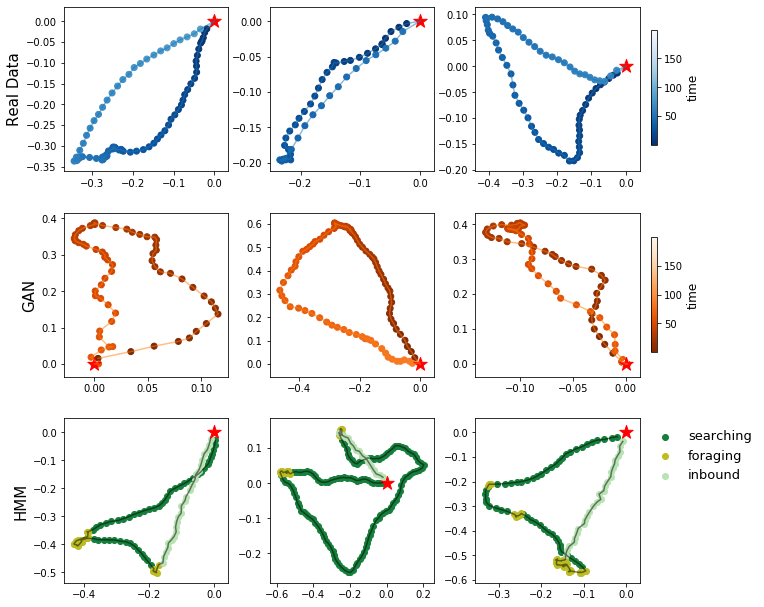

In [19]:
plt.figure(figsize=(8,8))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.25, hspace=0.25)

nb = [0,1,2]
traj_sim = traj_SV
i=0
for n in nb:
    i+=1
    plt.subplot(3,3,i)
    plt.plot(traj_sim[n,0,:], traj_sim[n,1,:], c = dicolour['blue'], alpha = 0.5)
    a = plt.scatter(traj_sim[n,0,:], traj_sim[n,1,:], c=np.arange(traj_sim.shape[2]), cmap='Blues_r')
    plt.scatter(0,0, c = 'red', marker ='*', s=200)
    if i%3 == 1:
        plt.ylabel('Real Data', fontsize=15)
        
nb = [2,6,12]
traj_sim = traj_GAN_SV
for n in nb:
    i+=1
    plt.subplot(3,3,i)
    plt.plot(traj_sim[n,0,:], traj_sim[n,1,:], c = dicolour['orange'], alpha = 0.5)
    b = plt.scatter(traj_sim[n,0,:], traj_sim[n,1,:], c=np.arange(traj_sim.shape[2]), cmap='Oranges_r')
    plt.scatter(0,0, c = 'red', marker ='*', s=200)
    if i%3 == 1:
        plt.ylabel('GAN', fontsize=15)

nb = [85, 87,88]
for n in nb:
    i+=1
    plt.subplot(3,3,i)
    traj = data_HMM_SV[data_HMM_SV.ID == n]
    
    plt.plot(traj.x_std, traj.y_std, c = 'black', alpha = 0.5)
    
    plt.scatter(traj.x_std[traj.states == 1], traj.y_std[traj.states == 1], label = 'searching', c= np.array([[0.0823529411764706, 0.49803921568627446, 0.23137254901960783, 1.0]]))
    plt.scatter(traj.x_std[traj.states == 2], traj.y_std[traj.states == 2], label = 'foraging', c= dicolour['yellow'])
    plt.scatter(traj.x_std[traj.states == 3], traj.y_std[traj.states == 3], label = 'inbound', c= np.array([[0.723121876201461, 0.8896116878123799, 0.6971780084582853, 1.0]]))
    plt.scatter(0,0, c = 'red', marker ='*', s=200)
    if i%3 == 1:
        plt.ylabel('HMM', fontsize=15)
    
plt.legend(frameon = False, bbox_to_anchor=(1,1), fontsize = 13)


cax = plt.axes([1.02, 0.76, 0.01, 0.2])
cbar = plt.colorbar(a, cax=cax, ticks=[50, 100, 150])
cbar.set_label('time', fontsize=12)

cax = plt.axes([1.02, 0.4, 0.01, 0.2])
cbar = plt.colorbar(b, cax=cax, label = 'time', ticks=[50, 100, 150])
cbar.set_label('time', fontsize=12)


plt.show()

In [20]:
# cmap = plt.cm.get_cmap('Greens')
# rgba = cmap(0.3)
# rgba

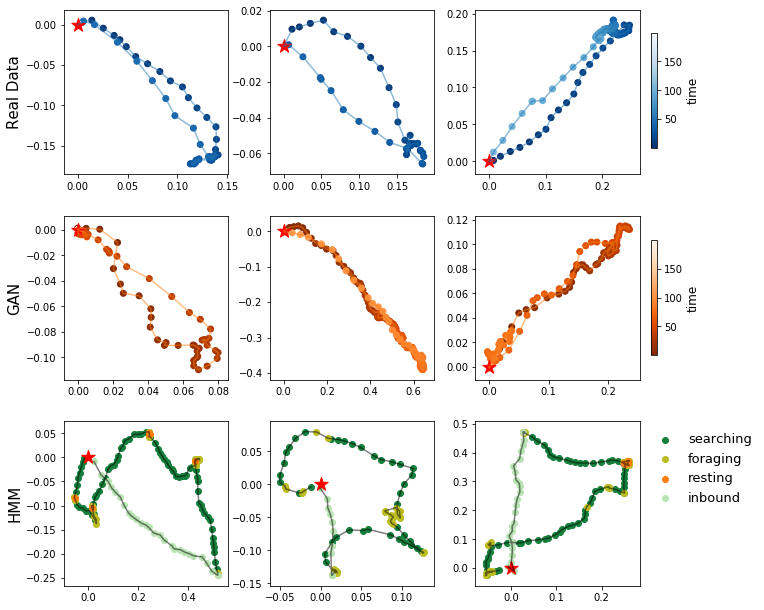

In [21]:
plt.figure(figsize=(8,8))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.25, hspace=0.25)

nb = [0,1,2]
traj_sim = traj_SD
i=0
for n in nb:
    i+=1
    plt.subplot(3,3,i)
    plt.plot(traj_sim[n,0,:], traj_sim[n,1,:], c = dicolour['blue'], alpha = 0.5)
    a = plt.scatter(traj_sim[n,0,:], traj_sim[n,1,:], c=np.arange(traj_sim.shape[2]), cmap='Blues_r')
    plt.scatter(0,0, c = 'red', marker ='*', s=200)
    if i%3 == 1:
        plt.ylabel('Real Data', fontsize=15)
        
nb = [12,9,14]
traj_sim = traj_GAN_SD
for n in nb:
    i+=1
    plt.subplot(3,3,i)
    plt.plot(traj_sim[n,0,:], traj_sim[n,1,:], c = dicolour['orange'], alpha = 0.5)
    b = plt.scatter(traj_sim[n,0,:], traj_sim[n,1,:], c=np.arange(traj_sim.shape[2]), cmap='Oranges_r')
    plt.scatter(0,0, c = 'red', marker ='*', s=200)
    if i%3 == 1:
        plt.ylabel('GAN', fontsize=15)

nb = [85, 15, 44]
for n in nb:
    i+=1
    plt.subplot(3,3,i)
    traj = data_HMM_SD[data_HMM_SD.ID == n]
    
    plt.plot(traj.x_std, traj.y_std, c = 'black', alpha = 0.5)
    
    plt.scatter(traj.x_std[traj.states == 1], traj.y_std[traj.states == 1], label = 'searching', c= np.array([[0.0823529411764706, 0.49803921568627446, 0.23137254901960783, 1.0]]))
    plt.scatter(traj.x_std[traj.states == 2], traj.y_std[traj.states == 2], label = 'foraging', c= dicolour['yellow'])
    plt.scatter(traj.x_std[traj.states == 3], traj.y_std[traj.states == 3], label = 'resting', c= dicolour['orange'])
    plt.scatter(traj.x_std[traj.states == 4], traj.y_std[traj.states == 4], label = 'inbound', c= np.array([[0.723121876201461, 0.8896116878123799, 0.6971780084582853, 1.0]]))
    plt.scatter(0,0, c = 'red', marker ='*', s=200)
    if i%3 == 1:
        plt.ylabel('HMM', fontsize=15)
plt.legend(frameon = False, bbox_to_anchor=(1,1), fontsize = 13)

cax = plt.axes([1.02, 0.76, 0.01, 0.2])
cbar = plt.colorbar(a, cax=cax, ticks=[50, 100, 150])
cbar.set_label('time', fontsize=12)

cax = plt.axes([1.02, 0.4, 0.01, 0.2])
cbar = plt.colorbar(b, cax=cax, label = 'time', ticks=[50, 100, 150])
cbar.set_label('time', fontsize=12)


plt.show()

In [22]:
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import matplotlib.markers as mk
from netCDF4 import Dataset

from scipy.optimize import minimize

In [23]:
def fun(t, f, k):
    np.sum(f[f > t])/np.sum(f)
    return abs(np.sum(f[f > t])/np.sum(f) - k)

Text(0.5, 1.0, 'HMM')

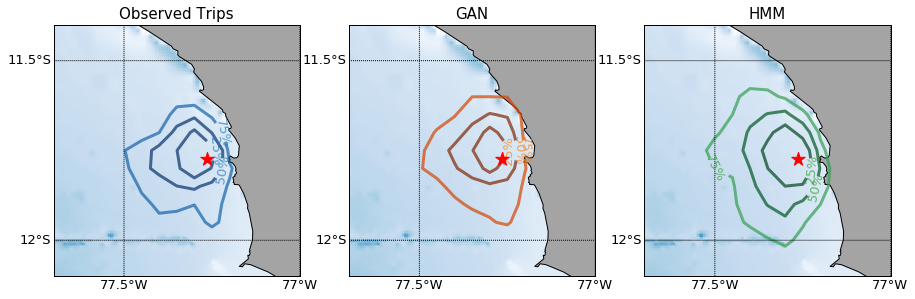

In [24]:
plt.figure(figsize=(15,10))

A1 = (-77.7, -77, -12.1, -11.4)
long_min, long_max = A1[0], A1[1]
lat_min, lat_max = A1[2], A1[3]


plt.subplot(1,3,1)

lon = data_SV.lon[data_SV.trip.isin(data_SV.trip.unique())]
lat = data_SV.lat[data_SV.trip.isin(data_SV.trip.unique())]
nb = len(data_SV.trip.unique())

# Define the grid
xx, yy = np.mgrid[long_min:long_max:0.05, lat_min:lat_max:0.05]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Peform the kernel density estimate
values = np.vstack([lon, lat])
kernel = st.gaussian_kde(values)
kernel.set_bandwidth(bw_method=0.3)

# Compute the grid
f = np.reshape(kernel(positions).T, xx.shape)
lvl = [minimize(fun, 2, (f, k), tol=1e-6, method = 'Nelder-Mead').x for k in [0.75, 0.5, 0.25]]
f_SV = f

# create map using BASEMAP
m = Basemap(llcrnrlon=long_min,
            llcrnrlat=lat_min,
            urcrnrlon=long_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(long_max-long_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )
# coast line and continents
m.drawcoastlines()
m.drawmapboundary(fill_color='#CEECF5')
m.fillcontinents(color = '#A4A4A4',lake_color='#CEECF5')
# meridians and parallels
parallels = np.arange(-15,-5,0.5)
meridians = np.arange(-80,-75,0.5)
labels = [True,False,False,True]
m.drawparallels(parallels, labels = labels, fontsize = 13)
m.drawmeridians(meridians, labels = labels, fontsize = 13)
# bathymetry
gebco = Dataset('/home/amdroy/MEGA/DATA/SATELLITE/GEBCO/gebco_2019_pescadores.nc')
lat_gebco = gebco.variables['lat'][:]
lon_gebco = gebco.variables['lon'][:]
lon_gebco, lat_gebco = np.meshgrid(lon_gebco, lat_gebco)
bathy = gebco.variables['elevation'][:]
m.pcolormesh(lon_gebco, lat_gebco, bathy, latlon = True, cmap='Blues_r', vmin = -800, vmax=100)    

# # trips
# x, y = m(lon.values, lat.values)
# plt.plot(x, y, alpha= .3, color = 'black')

## colony
x, y = m(-77.264, -11.773)
plt.scatter(x, y, marker = '*', s = 200, color = 'red', zorder=1e3)

## contour
CS = m.contour(xx, yy, f, latlon = True, cmap='Blues', levels = np.array(lvl).reshape(3), 
                  alpha = 0.7, linewidths = 3, vmin = -5, vmax = 7)
fmt = {}
strs = ['75%', '50%', '25%']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
    
# manual_locations = [m(-77.3, -12), m(-77.3, -11.95), 
#                     m(-77.3, -11.9), m(-77.3, -11.85),
#                    m(-77.37, -11.58)]
plt.clabel(CS, fontsize=13, inline_spacing = 10, inline=True, fmt = fmt, colors=dicolour['blue'])
plt.title('Observed Trips', fontsize = 15)




plt.subplot(1,3,2)
lon = data_GAN_SV.lon[data_GAN_SV.trip.isin(data_GAN_SV.trip.unique())]
lat = data_GAN_SV.lat[data_GAN_SV.trip.isin(data_GAN_SV.trip.unique())]
nb = len(data_GAN_SV.trip.unique())

# Define the grid
xx, yy = np.mgrid[long_min:long_max:0.05, lat_min:lat_max:0.05]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Peform the kernel density estimate
values = np.vstack([lon, lat])
kernel = st.gaussian_kde(values)
kernel.set_bandwidth(bw_method=0.3)

# Compute the grid
f = np.reshape(kernel(positions).T, xx.shape)
lvl = [minimize(fun, 1, (f, k), tol=1e-6, method = 'Powell').x for k in [0.75, 0.5, 0.25]]
f_GAN_SV = f

# create map using BASEMAP
m = Basemap(llcrnrlon=long_min,
            llcrnrlat=lat_min,
            urcrnrlon=long_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(long_max-long_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )
# coast line and continents
m.drawcoastlines()
m.drawmapboundary(fill_color='#CEECF5')
m.fillcontinents(color = '#A4A4A4',lake_color='#CEECF5')
# meridians and parallels
parallels = np.arange(-15,-5,0.5)
meridians = np.arange(-80,-75,0.5)
labels = [True,False,False,True]
m.drawparallels(parallels, labels = labels, fontsize = 13)
m.drawmeridians(meridians, labels = labels, fontsize = 13)
# bathymetry
gebco = Dataset('/home/amdroy/MEGA/DATA/SATELLITE/GEBCO/gebco_2019_pescadores.nc')
lat_gebco = gebco.variables['lat'][:]
lon_gebco = gebco.variables['lon'][:]
lon_gebco, lat_gebco = np.meshgrid(lon_gebco, lat_gebco)
bathy = gebco.variables['elevation'][:]
m.pcolormesh(lon_gebco, lat_gebco, bathy, latlon = True, cmap='Blues_r', vmin = -800, vmax=100)    

# # trips
# x, y = m(lon.values, lat.values)
# plt.plot(x, y, alpha= .9, color = dicolour['blue'])

## colony
x, y = m(-77.264, -11.773)
plt.scatter(x, y, marker = '*', s = 200, color = 'red', zorder=1e3)

## contour
CS = m.contour(xx, yy, f, latlon = True, cmap='Oranges', levels = np.array(lvl).reshape(3), 
                  alpha = 0.7, linewidths = 3, vmin = -5, vmax = 7)
fmt = {}
strs = ['75%', '50%', '25%']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
    
# manual_locations = [m(-77.3, -12), m(-77.3, -11.95), 
#                     m(-77.3, -11.9), m(-77.3, -11.85),
#                    m(-77.37, -11.58)]
plt.clabel(CS, fontsize=13, inline_spacing = 10, inline=True, fmt = fmt, colors=dicolour['orange'])
plt.title('GAN', fontsize = 15)


plt.subplot(1,3,3)
lon = data_HMM_SV.lon[data_HMM_SV.trip.isin(data_HMM_SV.trip.unique())]
lat = data_HMM_SV.lat[data_HMM_SV.trip.isin(data_HMM_SV.trip.unique())]
nb = len(data_HMM_SV.trip.unique())

# Define the grid
xx, yy = np.mgrid[long_min:long_max:0.05, lat_min:lat_max:0.05]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Peform the kernel density estimate
values = np.vstack([lon, lat])
kernel = st.gaussian_kde(values)
kernel.set_bandwidth(bw_method=0.3)

# Compute the grid
f = np.reshape(kernel(positions).T, xx.shape)
lvl = [minimize(fun, 2, (f, k), tol=1e-6, method = 'Powell').x for k in [0.75, 0.5, 0.25]]
f_HMM_SV = f

# create map using BASEMAP
m = Basemap(llcrnrlon=long_min,
            llcrnrlat=lat_min,
            urcrnrlon=long_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(long_max-long_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )
# coast line and continents
m.drawcoastlines()
m.drawmapboundary(fill_color='#CEECF5')
m.fillcontinents(color = '#A4A4A4',lake_color='#CEECF5')
# meridians and parallels
parallels = np.arange(-15,-5,0.5)
meridians = np.arange(-80,-75,0.5)
labels = [True,False,False,True]
m.drawparallels(parallels, labels = labels, fontsize = 13)
m.drawmeridians(meridians, labels = labels, fontsize = 13)
# bathymetry
gebco = Dataset('/home/amdroy/MEGA/DATA/SATELLITE/GEBCO/gebco_2019_pescadores.nc')
lat_gebco = gebco.variables['lat'][:]
lon_gebco = gebco.variables['lon'][:]
lon_gebco, lat_gebco = np.meshgrid(lon_gebco, lat_gebco)
bathy = gebco.variables['elevation'][:]
m.pcolormesh(lon_gebco, lat_gebco, bathy, latlon = True, cmap='Blues_r', vmin = -800, vmax=100)    

# # trips
# x, y = m(lon.values, lat.values)
# plt.plot(x, y, alpha= .9, color = dicolour['blue'])

## colony
x, y = m(-77.264, -11.773)
plt.scatter(x, y, marker = '*', s = 200, color = 'red', zorder=1e3)

## contour
CS = m.contour(xx, yy, f, latlon = True, cmap='Greens', levels = np.array(lvl).reshape(3), 
                  alpha = 0.7, linewidths = 3, vmin = -5, vmax = 7)
fmt = {}
strs = ['75%', '50%', '25%']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
    
# manual_locations = [m(-77.3, -12), m(-77.3, -11.95), 
#                     m(-77.3, -11.9), m(-77.3, -11.85),
#                    m(-77.37, -11.58)]
plt.clabel(CS, fontsize=13, inline_spacing = 10, inline=True, fmt = fmt, colors=dicolour['green'])
plt.title('HMM', fontsize = 15)


Text(0.5, 1.0, 'HMM')

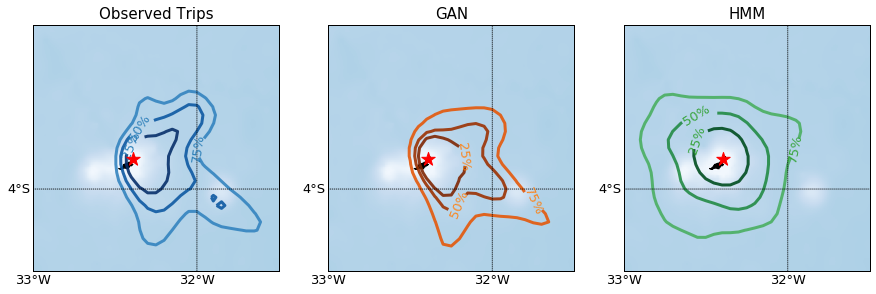

In [25]:
plt.figure(figsize=(15,10))


A1 = (-33, -31.5, -4.5, -3)
long_min, long_max = A1[0], A1[1]
lat_min, lat_max = A1[2], A1[3]

lon = data_SD.lon[data_SD.trip.isin(data_SD.trip.unique())]
lat = data_SD.lat[data_SD.trip.isin(data_SD.trip.unique())]
nb = len(data_SD.trip.unique())

# Define the grid
xx, yy = np.mgrid[long_min:long_max:0.05, lat_min:lat_max:0.05]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Peform the kernel density estimate
values = np.vstack([lon, lat])
kernel = st.gaussian_kde(values)
kernel.set_bandwidth(bw_method=0.3)

# Compute the grid
f = np.reshape(kernel(positions).T, xx.shape)
lvl = [minimize(fun, 1, (f, k), tol=1e-6, method = 'Powell').x for k in [0.75, 0.5, 0.25]]
f_SD = f

plt.subplot(1,3,1)
ax = plt.gca()
# create map using BASEMAP
m = Basemap(llcrnrlon=long_min,
            llcrnrlat=lat_min,
            urcrnrlon=long_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(long_max-long_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )

# coast line and continents
m.drawcoastlines()
m.drawmapboundary(fill_color='#CEECF5')
m.fillcontinents(color = '#A4A4A4',lake_color='#CEECF5')
m.readshapefile('/home/amdroy/MEGA/DATA/SHAPEFILE/Fernando/Fernandho_OSM_NE', 'Fernandho_OSM_NE',drawbounds=False)
patches   = []
for info, shape in zip(m.Fernandho_OSM_NE_info, m.Fernandho_OSM_NE):
    patches.append( Polygon(np.array(shape), True) )       
ax.add_collection(PatchCollection(patches, facecolor= 'k', edgecolor='k', linewidths=1., zorder=2))
# meridians and parallels
parallels = np.arange(-15,0,1)
meridians = np.arange(-40,-20,1)
labels = [True,False,False,True]
m.drawparallels(parallels, labels = labels, fontsize = 13)
m.drawmeridians(meridians, labels = labels, fontsize = 13)
# bathymetry
gebco = Dataset('/home/amdroy/MEGA/DATA/SATELLITE/GEBCO/gebco_2019_fernando.nc')
lat_gebco = gebco.variables['lat'][:]
lon_gebco = gebco.variables['lon'][:]
lon_gebco, lat_gebco = np.meshgrid(lon_gebco, lat_gebco)
bathy = gebco.variables['elevation'][:]
m.pcolormesh(lon_gebco, lat_gebco, bathy, latlon = True, cmap='Blues_r', vmin = -15000, vmax=500)
# trips
# x, y = m(lon.values, lat.values)
# m.plot(x, y, alpha= 1, color = dicolour['blue'])
# m.scatter(x, y, marker = 'o', s = 30*(weight>0.5), alpha= 0.5, edgecolors = None, color = dicolour['red'])

## contour
CS = m.contour(xx, yy, f, latlon = True, cmap='Blues', levels = np.array(lvl).reshape(3), 
                  alpha = 0.9, linewidths = 3, vmin = -2, vmax = 2)
fmt = {}
strs = ['75%', '50%', '25%']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
    
# manual_locations = [m(-77.3, -12), m(-77.3, -11.95), 
#                     m(-77.3, -11.9), m(-77.3, -11.85),
#                    m(-77.37, -11.58)]
plt.clabel(CS, fontsize=13, inline_spacing = 10, inline=True, fmt = fmt, colors=dicolour['blue'])
## colony
x, y = m(-32.392, -3.819)
m.scatter(x, y, marker = '*', s = 200, color = 'red', alpha= 1, zorder = 1e3)
# xt, yt = m(-33.4, -3)
# plt.annotate('Fernando de Noronha', xy = (x, y), fontsize = 15, xytext = (xt, yt), 
#              bbox = dict(boxstyle="round", fc="0.8"),
#             arrowprops = dict(arrowstyle = '->', color = 'k', lw = 2))
plt.title('Observed Trips', fontsize = 15)


lon = data_GAN_SD.lon[data_GAN_SD.trip.isin(data_GAN_SD.trip.unique())]
lat = data_GAN_SD.lat[data_GAN_SD.trip.isin(data_GAN_SD.trip.unique())]
nb = len(data_GAN_SD.trip.unique())

# Define the grid
xx, yy = np.mgrid[long_min:long_max:0.05, lat_min:lat_max:0.05]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Peform the kernel density estimate
values = np.vstack([lon, lat])
kernel = st.gaussian_kde(values)
kernel.set_bandwidth(bw_method=0.3)

# Compute the grid
f = np.reshape(kernel(positions).T, xx.shape)
lvl = [minimize(fun, 1, (f, k), tol=1e-6, method = 'Powell').x for k in [0.75, 0.5, 0.25]]
f_GAN_SD = f

plt.subplot(1,3,2)
ax = plt.gca()
# create map using BASEMAP
m = Basemap(llcrnrlon=long_min,
            llcrnrlat=lat_min,
            urcrnrlon=long_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(long_max-long_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )

# coast line and continents
m.drawcoastlines()
m.drawmapboundary(fill_color='#CEECF5')
m.fillcontinents(color = '#A4A4A4',lake_color='#CEECF5')
m.readshapefile('/home/amdroy/MEGA/DATA/SHAPEFILE/Fernando/Fernandho_OSM_NE', 'Fernandho_OSM_NE',drawbounds=False)
patches   = []
for info, shape in zip(m.Fernandho_OSM_NE_info, m.Fernandho_OSM_NE):
    patches.append( Polygon(np.array(shape), True) )       
ax.add_collection(PatchCollection(patches, facecolor= 'k', edgecolor='k', linewidths=1., zorder=2))
# meridians and parallels
parallels = np.arange(-15,0,1)
meridians = np.arange(-40,-20,1)
labels = [True,False,False,True]
m.drawparallels(parallels, labels = labels, fontsize = 13)
m.drawmeridians(meridians, labels = labels, fontsize = 13)
# bathymetry
gebco = Dataset('/home/amdroy/MEGA/DATA/SATELLITE/GEBCO/gebco_2019_fernando.nc')
lat_gebco = gebco.variables['lat'][:]
lon_gebco = gebco.variables['lon'][:]
lon_gebco, lat_gebco = np.meshgrid(lon_gebco, lat_gebco)
bathy = gebco.variables['elevation'][:]
m.pcolormesh(lon_gebco, lat_gebco, bathy, latlon = True, cmap='Blues_r', vmin = -15000, vmax=500)
# # trips
# x, y = m(lon.values, lat.values)
# m.plot(x, y, alpha= 1, color = dicolour['orange'])
# m.scatter(x, y, marker = 'o', s = 30*(weight>0.5), alpha= 0.5, edgecolors = None, color = dicolour['red'])
## contour
CS = m.contour(xx, yy, f, latlon = True, cmap='Oranges', levels = np.array(lvl).reshape(3), 
                  alpha = 0.9, linewidths = 3, vmin = -2, vmax = 2)
fmt = {}
strs = ['75%', '50%', '25%']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
    
# manual_locations = [m(-77.3, -12), m(-77.3, -11.95), 
#                     m(-77.3, -11.9), m(-77.3, -11.85),
#                    m(-77.37, -11.58)]
plt.clabel(CS, fontsize=13, inline_spacing = 10, inline=True, fmt = fmt, colors=dicolour['orange'])
## colony
x, y = m(-32.392, -3.819)
m.scatter(x, y, marker = '*', s = 200, color = 'red', alpha= 1, zorder = 1e3)
# xt, yt = m(-33.4, -3)
# plt.annotate('Fernando de Noronha', xy = (x, y), fontsize = 15, xytext = (xt, yt), 
#              bbox = dict(boxstyle="round", fc="0.8"),
#             arrowprops = dict(arrowstyle = '->', color = 'k', lw = 2))
plt.title('GAN', fontsize = 15)


lon = data_HMM_SD.lon[data_HMM_SD.trip.isin(data_HMM_SD.trip.unique())]
lat = data_HMM_SD.lat[data_HMM_SD.trip.isin(data_HMM_SD.trip.unique())]
nb = len(data_HMM_SD.trip.unique())

# Define the grid
xx, yy = np.mgrid[long_min:long_max:0.05, lat_min:lat_max:0.05]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Peform the kernel density estimate
values = np.vstack([lon, lat])
kernel = st.gaussian_kde(values)
kernel.set_bandwidth(bw_method=0.3)

# Compute the grid
f = np.reshape(kernel(positions).T, xx.shape)
lvl = [minimize(fun, 2, (f, k), tol=1e-6, method = 'Powell').x for k in [0.75, 0.5, 0.25]]
f_HMM_SD = f

plt.subplot(1,3,3)
ax = plt.gca()
# create map using BASEMAP
m = Basemap(llcrnrlon=long_min,
            llcrnrlat=lat_min,
            urcrnrlon=long_max,
            urcrnrlat=lat_max,
            lat_0=(lat_max - lat_min)/2,
            lon_0=(long_max-long_min)/2,
            projection='merc',
            resolution = 'h',
            area_thresh=10000.,
            )

# coast line and continents
m.drawcoastlines()
m.drawmapboundary(fill_color='#CEECF5')
m.fillcontinents(color = '#A4A4A4',lake_color='#CEECF5')
m.readshapefile('/home/amdroy/MEGA/DATA/SHAPEFILE/Fernando/Fernandho_OSM_NE', 'Fernandho_OSM_NE',drawbounds=False)
patches   = []
for info, shape in zip(m.Fernandho_OSM_NE_info, m.Fernandho_OSM_NE):
    patches.append( Polygon(np.array(shape), True) )       
ax.add_collection(PatchCollection(patches, facecolor= 'k', edgecolor='k', linewidths=1., zorder=2))
# meridians and parallels
parallels = np.arange(-15,0,1)
meridians = np.arange(-40,-20,1)
labels = [True,False,False,True]
m.drawparallels(parallels, labels = labels, fontsize = 13)
m.drawmeridians(meridians, labels = labels, fontsize = 13)
# bathymetry
gebco = Dataset('/home/amdroy/MEGA/DATA/SATELLITE/GEBCO/gebco_2019_fernando.nc')
lat_gebco = gebco.variables['lat'][:]
lon_gebco = gebco.variables['lon'][:]
lon_gebco, lat_gebco = np.meshgrid(lon_gebco, lat_gebco)
bathy = gebco.variables['elevation'][:]
m.pcolormesh(lon_gebco, lat_gebco, bathy, latlon = True, cmap='Blues_r', vmin = -15000, vmax=500)
# trips
# x, y = m(lon.values, lat.values)
# m.plot(x, y, alpha= 1, color = dicolour['green'])
# m.scatter(x, y, marker = 'o', s = 30*(weight>0.5), alpha= 0.5, edgecolors = None, color = dicolour['red'])
## contour
CS = m.contour(xx, yy, f, latlon = True, cmap='Greens', levels = np.array(lvl).reshape(3), 
                  alpha = 0.9, linewidths = 3, vmin = -2, vmax = 2)
fmt = {}
strs = ['75%', '50%', '25%']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
    
# manual_locations = [m(-77.3, -12), m(-77.3, -11.95), 
#                     m(-77.3, -11.9), m(-77.3, -11.85),
#                    m(-77.37, -11.58)]
plt.clabel(CS, fontsize=13, inline_spacing = 10, inline=True, fmt = fmt, colors=dicolour['green'])
## colony
x, y = m(-32.392, -3.819)
m.scatter(x, y, marker = '*', s = 200, color = 'red', alpha= 1, zorder = 1e3)
# xt, yt = m(-33.4, -3)
# plt.annotate('Fernando de Noronha', xy = (x, y), fontsize = 15, xytext = (xt, yt), 
#              bbox = dict(boxstyle="round", fc="0.8"),
#             arrowprops = dict(arrowstyle = '->', color = 'k', lw = 2))
plt.title('HMM', fontsize = 15)

In [26]:
print(np.mean((f_SV - f_GAN_SV)**2))
print(np.mean((f_SV - f_HMM_SV)**2))

print(np.mean((f_SD - f_GAN_SD)**2))
print(np.mean((f_SD - f_HMM_SD)**2))

1.0893728333295427
2.635785733447416
0.028819148849791157
0.3200403863541066


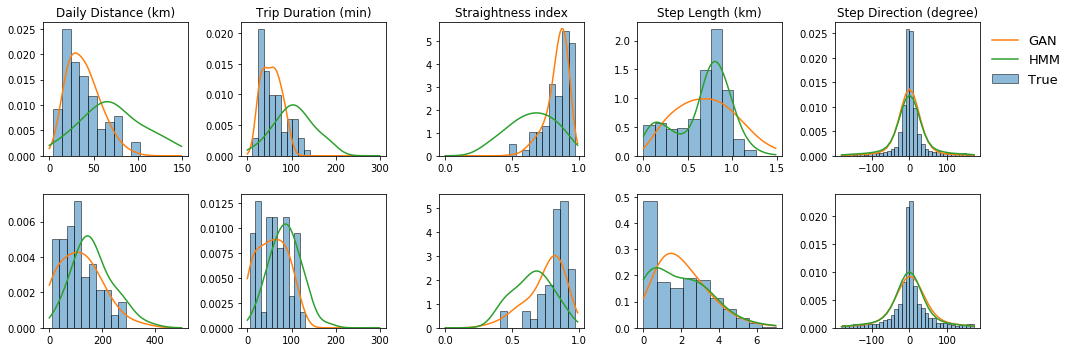

In [37]:
data = data_SV
simGAN = data_GAN_SV
simHMM = data_HMM_SV

plt.figure(figsize = (15,5))

plt.subplot(2,5,1)
## DAILY DISTANCE
y = get_trip_dist(data)

y_GAN = get_trip_dist(simGAN)
y_HMM = get_trip_dist(simHMM)
dy_GAN = kde1d(y_GAN/1e3, bw = 0.5)
dy_HMM = kde1d(y_HMM/1e3, bw = 0.5)

bins = np.arange(0, 150, 10)
# plt.hist(y/1e3, alpha = 0.5, edgecolor='k', bins = bins, density = True, color = dicolour['blue'], label = 'True')
# plt.hist(y_false/1e3, alpha = 0.5, edgecolor='k', bins = bins, density = True, color = dicolour['orange'], label = 'Simulation')
x = np.arange(0,150, 1)
plt.hist(y/1e3, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
plt.title('Daily Distance (km)')

plt.subplot(2,5,2)
## FORAGING DURATION
y = get_trip_duration(data)
y_GAN = get_trip_duration(simGAN)
y_HMM = get_trip_duration(simHMM)
dy_GAN = kde1d(y_GAN, bw = 0.5)
dy_HMM = kde1d(y_HMM, bw = 0.5)

bins = np.arange(0, 300, 15)
# plt.hist(y, alpha = 0.5, edgecolor='k', bins = bins, density = True, color = dicolour['blue'], label = 'True')
# plt.hist(y_false, alpha = 0.5, edgecolor='k', bins = bins, density = True, color = dicolour['orange'], label = 'Simulation')

x = np.arange(0,300, 1)
plt.hist(y, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
plt.title('Trip Duration (min)')

plt.subplot(2,5,3)
# STRAIGHTNESS INDEX
y = get_trip_sinuosity(data)
y_GAN = get_trip_sinuosity(simGAN)
y_HMM = get_trip_sinuosity(simHMM)
dy_GAN = kde1d(y_GAN, bw = 0.5)
dy_HMM = kde1d(y_HMM, bw = 0.5)

x = np.arange(0,1, 0.01)
plt.hist(y, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
plt.title('Straightness index')

plt.subplot(2,5,4)
# STEP LENGTH
y_GAN = simGAN.step_distance/1e3
y_HMM = simHMM.step_distance/1e3
dy_GAN = kde1d(y_GAN.dropna(), bw = 0.3)
dy_HMM = kde1d(y_HMM.dropna(), bw = 0.3)

x = np.arange(0,1.5, 0.01)
plt.hist(data.step_distance.dropna()/1e3, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
plt.title('Step Length (km)')

plt.subplot(2,5,5)
# STEP DIRECTION
y_GAN = simGAN.step_direction
y_HMM = simHMM.step_direction
dy_GAN = kde1d(y_GAN.dropna(), bw = 0.5)
dy_HMM = kde1d(y_HMM.dropna(), bw = 0.5)

x = np.arange(-180,180, 10)
plt.hist(data.step_direction, bins = x, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
plt.title('Step Direction (degree)')
# score_foraging_times = np.sum((dy_false/np.sum(dy_false) - dy/np.sum(dy))**2) / np.sum( (dy/np.sum(dy))**2)
plt.legend(frameon=False, fontsize = 13, bbox_to_anchor=(1,1))


data = data_SD
simGAN = data_GAN_SD
simHMM = data_HMM_SD


plt.subplot(2,5,6)
## DAILY DISTANCE
y = get_trip_dist(data)

y_GAN = get_trip_dist(simGAN)
y_HMM = get_trip_dist(simHMM)
dy_GAN = kde1d(y_GAN/1e3, bw = 0.5)
dy_HMM = kde1d(y_HMM/1e3, bw = 0.5)

bins = np.arange(0, 500, 10)
# plt.hist(y/1e3, alpha = 0.5, edgecolor='k', bins = bins, density = True, color = dicolour['blue'], label = 'True')
# plt.hist(y_false/1e3, alpha = 0.5, edgecolor='k', bins = bins, density = True, color = dicolour['orange'], label = 'Simulation')
x = np.arange(0,500, 1)
plt.hist(y/1e3, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
# plt.legend()
# plt.title('Daily Distance (km)')

plt.subplot(2,5,7)
## FORAGING DURATION
y = get_trip_duration(data)
y_GAN = get_trip_duration(simGAN)
y_HMM = get_trip_duration(simHMM)
dy_GAN = kde1d(y_GAN, bw = 0.5)
dy_HMM = kde1d(y_HMM, bw = 0.5)

bins = np.arange(0, 300, 15)
x = np.arange(0,300, 1)
plt.hist(y, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
# plt.title('Trip Duration (min)')

plt.subplot(2,5,8)
# STRAIGHTNESS INDEX
y = get_trip_sinuosity(data)
y_GAN = get_trip_sinuosity(simGAN)
y_HMM = get_trip_sinuosity(simHMM)
dy_GAN = kde1d(y_GAN, bw = 0.5)
dy_HMM = kde1d(y_HMM, bw = 0.5)

x = np.arange(0,1, 0.01)
plt.hist(y, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
# plt.title('Straightness index')


plt.subplot(2,5,9)
# STEP LENGTH
y_GAN = simGAN.step_distance/1e3
y_HMM = simHMM.step_distance/1e3
dy_GAN = kde1d(y_GAN.dropna(), bw = 0.5)
dy_HMM = kde1d(y_HMM.dropna(), bw = 0.5)

x = np.arange(0,7, 0.01)
plt.hist(data.step_distance.dropna()/1e3, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
# plt.title('Step Length (km)')

plt.subplot(2,5,10)
# STEP DIRECTION
y_GAN = simGAN.step_direction
y_HMM = simHMM.step_direction
dy_GAN = kde1d(y_GAN.dropna(), bw = 0.5)
dy_HMM = kde1d(y_HMM.dropna(), bw = 0.5)

x = np.arange(-180,180, 10)
plt.hist(data.step_direction, bins = x, color = dicolour['blue'], label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_GAN(x), color = dicolour['orange'], label = 'GAN')
plt.plot(x, dy_HMM(x), color = dicolour['green'], label = 'HMM')
# plt.title('Step Direction (degree)')
# score_foraging_tim3es = np.sum((dy_false/np.sum(dy_false) - dy/np.sum(dy))**2) / np.sum( (dy/np.sum(dy))**2)

plt.tight_layout(h_pad = 2)
plt.show()

In [28]:
import scipy.signal

In [29]:
def get_periodogram(traj):    
    periodogram_lon = []
    periodogram_lat = []

    for j in range(traj.shape[0]):
        lon = traj[j, 0, :]
        lat = traj[j, 1, :]
        x, lon = scipy.signal.periodogram(lon, scaling = 'density', detrend = False)
        x, lat = scipy.signal.periodogram(lat, scaling = 'density', detrend = False)
        
        periodogram_lon.append(lon)
        periodogram_lat.append(lat)
        
    return (x, np.array(periodogram_lon), np.array(periodogram_lat))
    

0.07579363844215839
0.9163766448754214
0.0684170780929993
0.8881356437677398


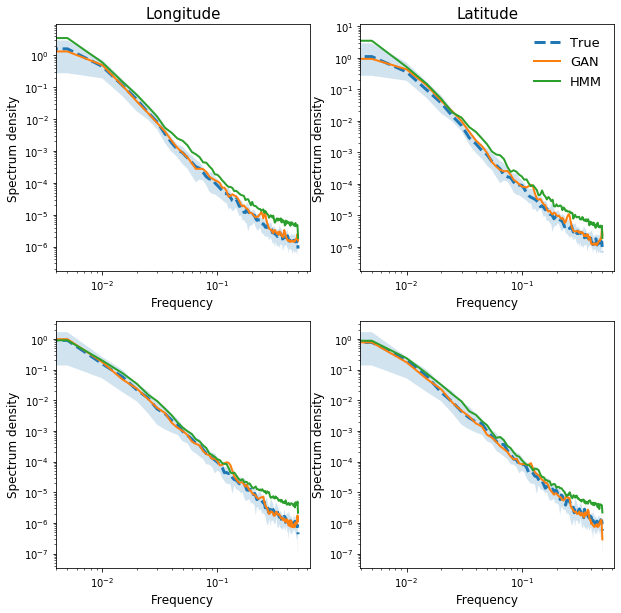

In [30]:
plt.figure(figsize = (10,10))

x, lon, lat = get_periodogram(traj_SV)
x, lon_GAN, lat_GAN = get_periodogram(traj_GAN_SV)
x, lon_HMM, lat_HMM = get_periodogram(traj_HMM_SV)


plt.subplot(2,2,1)
plt.loglog(x, np.mean(lon, axis=0), linewidth = 3, linestyle = '--')
plt.fill_between(x, np.mean(lon, axis=0) - 0.5 * np.std(lon, axis=0) ,  
                 np.mean(lon, axis=0) + 0.5 * np.std(lon, axis=0),
                alpha = 0.2)
plt.loglog(x, np.mean(lon_GAN, axis=0), linewidth = 2)
plt.loglog(x, np.mean(lon_HMM, axis=0), linewidth = 2)
plt.ylabel('Spectrum density', fontsize = 12)
plt.xlabel('Frequency', fontsize = 12)
plt.title('Longitude', fontsize = 15)
# plt.ylabel('Sula variegata', fontsize = 15)

plt.subplot(2,2,2)
plt.loglog(x, np.mean(lat, axis=0), linewidth = 3, linestyle = '--', label = 'True')
plt.fill_between(x, np.mean(lon, axis=0) - 0.5 * np.std(lon, axis=0) ,  
                 np.mean(lon, axis=0) + 0.5 * np.std(lon, axis=0),
                alpha = 0.2)
plt.loglog(x, np.mean(lat_GAN, axis=0), linewidth = 2, label = 'GAN')
plt.loglog(x, np.mean(lat_HMM, axis=0), linewidth = 2, label = 'HMM')
plt.ylabel('Spectrum density', fontsize = 12)
plt.xlabel('Frequency', fontsize = 12)
plt.legend(frameon = False, fontsize = 13)
plt.title('Latitude', fontsize = 15)


print(np.mean(np.log(np.mean(lon, axis=0) / np.mean(lon_GAN, axis=0))**2))
print(np.mean(np.log(np.mean(lon, axis=0) / np.mean(lon_HMM, axis=0))**2))

x, lon, lat = get_periodogram(traj_SD)
x, lon_GAN, lat_GAN = get_periodogram(traj_GAN_SD)
x, lon_HMM, lat_HMM = get_periodogram(traj_HMM_SD)

plt.subplot(2,2,3)
plt.loglog(x, np.mean(lon, axis=0), linewidth = 3, linestyle = '--')
plt.fill_between(x, np.mean(lon, axis=0) - 0.5 * np.std(lon, axis=0) ,  
                 np.mean(lon, axis=0) + 0.5 * np.std(lon, axis=0),
                alpha = 0.2)
plt.loglog(x, np.mean(lon_GAN, axis=0), linewidth = 2)
plt.loglog(x, np.mean(lon_HMM, axis=0), linewidth = 2)
plt.ylabel('Spectrum density', fontsize = 12)
plt.xlabel('Frequency', fontsize = 12)


plt.subplot(2,2,4)
plt.loglog(x, np.mean(lat, axis=0), linewidth = 3, linestyle = '--', label = 'True')
plt.fill_between(x, np.mean(lon, axis=0) - 0.5 * np.std(lon, axis=0) ,  
                 np.mean(lon, axis=0) + 0.5 * np.std(lon, axis=0),
                alpha = 0.2)
plt.loglog(x, np.mean(lat_GAN, axis=0), linewidth = 2, label = 'GAN')
plt.loglog(x, np.mean(lat_HMM, axis=0), linewidth = 2, label = 'HMM')
plt.ylabel('Spectrum density', fontsize = 12)
plt.xlabel('Frequency', fontsize = 12)

print(np.mean(np.log(np.mean(lon, axis=0) / np.mean(lon_GAN, axis=0))**2))
print(np.mean(np.log(np.mean(lon, axis=0) / np.mean(lon_HMM, axis=0))**2))

plt.show()

## render GIF

In [31]:
import imageio
import os

In [32]:
image = []
for im in os.listdir('../results/gif/traj'):
    if im[-3:] == 'png':
        image.append(im)
image.sort()

In [33]:
images = []
for im in image:
    images.append(imageio.imread('../results/gif/traj/'+im))
    
imageio.mimsave('../results/traj.gif', images, fps=1)